In [1]:
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [2]:
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [3]:
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

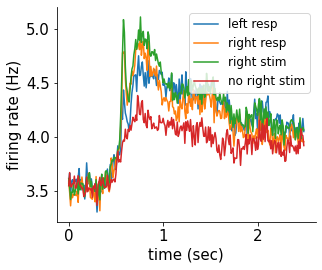

In [5]:
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# X = dat['spks'][barea==0][:,:,0:50].mean(axis=(2)).T
X = dat['spks'][barea==0][:,:,51:90].mean(axis=(2)).T
# X = dat['spks'][barea==0].mean(axis=(2)).T
# y = np.zeros_like(response)
# y[response >=0] = 1

y = np.zeros_like(response)
y[response < 0] = 0
y[response == 0] = 1
y[response > 0] = 2

print(dat['spks'].shape)
print((barea==0).sum())
print(X.shape)
print(y.shape)


(698, 340, 250)
145
(340, 145)
(340,)


In [7]:
log_reg = LogisticRegression(penalty="none", max_iter=10000)
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

print((y==y_pred).mean())
print(y_pred)

1.0
[1. 2. 1. 2. 0. 0. 0. 0. 2. 0. 0. 0. 2. 1. 0. 1. 2. 2. 2. 2. 2. 0. 2. 0.
 0. 1. 2. 2. 0. 1. 2. 0. 1. 1. 0. 0. 0. 2. 2. 2. 0. 1. 2. 0. 0. 2. 2. 0.
 2. 0. 0. 2. 0. 0. 0. 2. 2. 0. 0. 0. 1. 1. 0. 2. 1. 0. 0. 2. 1. 2. 2. 2.
 1. 2. 1. 2. 0. 2. 0. 2. 2. 2. 0. 1. 2. 0. 0. 1. 2. 2. 0. 2. 0. 2. 0. 0.
 1. 0. 2. 1. 0. 0. 0. 2. 2. 0. 1. 2. 2. 2. 2. 0. 1. 2. 0. 2. 1. 1. 0. 0.
 0. 0. 1. 2. 1. 1. 2. 0. 0. 1. 0. 0. 2. 0. 2. 0. 2. 0. 2. 0. 1. 2. 0. 0.
 2. 2. 0. 1. 0. 0. 1. 2. 2. 1. 1. 2. 1. 2. 2. 0. 2. 0. 2. 2. 0. 2. 2. 2.
 2. 0. 2. 2. 0. 0. 0. 1. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 1. 2. 0.
 0. 2. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 2. 0. 0. 0. 1. 2. 0.
 2. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 2. 2. 2. 2. 2. 0. 0. 0. 2. 0. 2. 0. 2.
 2. 0. 1. 2. 0. 2. 0. 2. 0. 2. 2. 2. 0. 2. 0. 2. 0. 2. 2. 2. 2. 0. 0. 2.
 2. 0. 2. 1. 2. 0. 2. 2. 2. 0. 2. 2. 0. 0. 0. 2. 2. 2. 2. 0. 2. 2. 0. 0.
 2. 2. 2. 2. 0. 0. 2. 2. 1. 2. 2. 2. 0. 1. 0. 2. 0. 0. 1. 0. 2. 2. 2. 1.
 0. 0. 0. 1. 2. 0. 0. 2. 2. 2. 0. 2. 2. 2. 0. 1

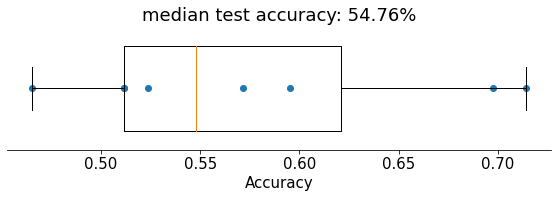

In [8]:
accuracies = cross_val_score(LogisticRegression(penalty='none', max_iter=10000), X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"median test accuracy: {np.median(accuracies):.2%}"
)
ax.spines["left"].set_visible(False)

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])
print(X.shape)
print(y.shape)

(340, 145)
(340,)


In [10]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
y_predicted = clf.predict(X)
print((y==y_predicted).mean())

0.9264705882352942


In [11]:
!pip install Neural-Decoding

In [12]:
#Import standard packages
%matplotlib inline
from scipy import io
from scipy import stats

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import SimpleRNNClassification
from Neural_Decoding.decoders import GRUClassification
from Neural_Decoding.decoders import LSTMClassification
from Neural_Decoding.decoders import WienerFilterClassification
from Neural_Decoding.decoders import SVClassification
from Neural_Decoding.decoders import DenseNNClassification
from Neural_Decoding.decoders import GRUClassification
from Neural_Decoding.decoders import XGBoostClassification

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [13]:
dat['spks'][barea==0].mean(axis=(0),keepdims=1).shape

(1, 340, 250)

In [14]:
print(dat['spks'][barea==0].shape)
## "number of observation" x "number of time bins"  x "number of neurons", 340,250,145 1, 2, 0 (transposed)
## "number of neurons" x "number of observation" x "number of time bins".  145,340,250 0, 1, 2 (original)

(145, 340, 250)


In [15]:
X = dat['spks'][barea==1].transpose((1,2,0))
X = X[:,51:80,:]
for i in range(5):
  X1 = dat['spks'][barea==i].transpose((1,2,0))
  X1 = X1.mean(axis=2)
  if i == 0:
    X_flat = X1
  X_flat = np.hstack((X_flat,X1))

y = np.zeros((len(response),1))
y[response == 0 ] = 1
y[response > 0 ] = 2

# y = np.zeros((len(response),3))
# y[response < 0, 0] = 1
# y[response == 0, 1] = 1
# y[response > 0, 2] = 1

In [16]:
X = dat['spks'][barea==1].transpose((1,2,0))
# X = X[:,51:80,:]
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
# X = dat['spks'][barea==0].mean(axis=(0),keepdims=1).transpose((1,2,0))
# X = X[:,0:100,:]

y = np.zeros((len(response),1))
y[response == 0 ] = 1
y[response > 0 ] = 2

# y = np.zeros((len(response),3))
# y[response < 0, 0] = 1
# y[response == 0, 1] = 1
# y[response > 0, 2] = 1

In [17]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.85]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [18]:
import random
num_examples=X.shape[0]
int_list = np.array([ x for x in range(num_examples)])
# print(int_list)
random.shuffle(int_list)
# print(int_list)

In [19]:

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples)),np.int(np.round(training_range[1]*num_examples)))
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples)),np.int(np.round(testing_range[1]*num_examples)))
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples)),np.int(np.round(valid_range[1]*num_examples)))

#Get training data
X_train=X[int_list[training_set],:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set]

#Get testing data
X_test=X[int_list[testing_set],:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set]

#Get validation data
X_valid=X[int_list[valid_set],:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set]

In [20]:
#Z-score "X" inputs. 
# X_train_mean=np.nanmean(X_train,axis=0)
# X_train_std=np.nanstd(X_train,axis=0)
# X_train=(X_train-X_train_mean)/X_train_std
# X_test=(X_test-X_train_mean)/X_train_std

In [21]:
model_rnn=SimpleRNNClassification(units=25,dropout=0,num_epochs=10,verbose=1)
#Fit model
model_rnn.fit(X_train,y_train)
#Get predictions
y_valid_predicted_rnn = model_rnn.predict(X_valid)
y_train_predicted_rnn = model_rnn.predict(X_train)

print((y_valid_predicted_rnn == y_valid[:,0]).mean())
print((y_train_predicted_rnn == y_train[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1307: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(25, input_shape=(250, 155), dropout=0, recurrent_dropout=0)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1316: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


Epoch 1/10
289/289 [==============================] - 1s 3ms/step - loss: 1.1034 - accuracy: 0.4014
Epoch 2/10
289/289 [==============================] - 0s 1ms/step - loss: 1.0218 - accuracy: 0.4567
Epoch 3/10
289/289 [==============================] - 0s 1ms/step - loss: 0.9928 - accuracy: 0.4706
Epoch 4/10
289/289 [==============================] - 0s 1ms/step - loss: 0.9682 - accuracy: 0.4844
Epoch 5/10
289/289 [==============================] - 0s 1ms/step - loss: 0.9473 - accuracy: 0.5121
Epoch 6/10
289/289 [==============================] - 0s 1ms/step - loss: 0.9241 - accuracy: 0.5536
Epoch 7/10
289/289 [==============================] - 0s 1ms/step - loss: 0.8989 - accuracy: 0.5848
Epoch 8/10
289/289 [==============================] - 0s 1ms/step - loss: 0.8769 - accuracy: 0.5952
Epoch 9/10
289/289 [==============================] - 0s 1ms/step - loss: 0.8513 - accuracy: 0.6159
Epoch 10/10
289/289 [==============================] - 0s 1ms/step - loss: 0.8295 - accuracy: 0.6436

In [22]:
#Declare model
model_lstm=LSTMClassification(units=25,dropout=0,num_epochs=10,verbose=1)
#Fit model
model_lstm.fit(X_train,y_train)
#Get predictions
y_train_predicted_lstm=model_lstm.predict(X_train)
y_valid_predicted_lstm=model_lstm.predict(X_valid)

print((y_train_predicted_lstm == y_train[:,0]).mean())
print((y_valid_predicted_lstm == y_valid[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1490: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, input_shape=(250, 155), dropout=0, recurrent_dropout=0)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1499: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


Epoch 1/10
289/289 [==============================] - 1s 4ms/step - loss: 1.0560 - accuracy: 0.4118
Epoch 2/10
289/289 [==============================] - 1s 3ms/step - loss: 1.0182 - accuracy: 0.4429
Epoch 3/10
289/289 [==============================] - 1s 3ms/step - loss: 1.0081 - accuracy: 0.4740
Epoch 4/10
289/289 [==============================] - 1s 3ms/step - loss: 1.0020 - accuracy: 0.4706
Epoch 5/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9926 - accuracy: 0.4671
Epoch 6/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9846 - accuracy: 0.5225
Epoch 7/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9754 - accuracy: 0.5398
Epoch 8/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9641 - accuracy: 0.4983
Epoch 9/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9571 - accuracy: 0.5744
Epoch 10/10
289/289 [==============================] - 1s 3ms/step - loss: 0.9442 - accuracy: 0.5709

In [23]:
#Declare model
model_wf=WienerFilterClassification()
#Fit model
model_wf.fit(X_flat_train,y_train)
#Get predictions
y_train_predicted_wf=model_wf.predict(X_flat_train)
y_valid_predicted_wf=model_wf.predict(X_flat_valid)
#Get metric of fit
print((y_train_predicted_wf == y_train[:,0]).mean())
print((y_valid_predicted_wf == y_valid[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
0.6274509803921569


In [24]:
#Declare model
model_svm=SVClassification(C=5, max_iter=4000)
#Fit model
model_svm.fit(X_flat_train,y_train)
#Get predictions
y_train_predicted_svm=model_svm.predict(X_flat_train)
y_valid_predicted_svm=model_svm.predict(X_flat_valid)
#Get metric of fit
print((y_train_predicted_svm == y_train[:,0]).mean())
print((y_valid_predicted_svm == y_valid[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0
0.5490196078431373


In [25]:
#Declare model
model_dnn=DenseNNClassification(units=[10],dropout=0.25,num_epochs=5,verbose=1)
#Fit model
model_dnn.fit(X_flat_train,y_train)
#Get predictions
y_train_predicted_dnn=model_dnn.predict(X_flat_train)
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
#Get metric of fit
print((y_train_predicted_dnn == y_train[:,0]).mean())
print((y_valid_predicted_dnn == y_valid[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1225: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


Epoch 1/5
289/289 [==============================] - 0s 652us/step - loss: 1.0735 - accuracy: 0.4118
Epoch 2/5
289/289 [==============================] - 0s 307us/step - loss: 0.9475 - accuracy: 0.4706
Epoch 3/5
289/289 [==============================] - 0s 313us/step - loss: 0.8519 - accuracy: 0.4567
Epoch 4/5
289/289 [==============================] - 0s 316us/step - loss: 0.8030 - accuracy: 0.4567
Epoch 5/5
289/289 [==============================] - 0s 312us/step - loss: 0.7164 - accuracy: 0.4740
0.4532871972318339
0.27450980392156865


In [26]:
#Declare model
model_gru=GRUClassification(units=100,dropout=0,num_epochs=10,verbose=1)
#Fit model
model_gru.fit(X_train,y_train)
#Get predictions
y_train_predicted_gru=model_gru.predict(X_train)
y_valid_predicted_gru=model_gru.predict(X_valid)
#Get metric of fit
print((y_train_predicted_gru == y_train[:,0]).mean())
print((y_valid_predicted_gru == y_valid[:,0]).mean())

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1399: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, input_shape=(250, 155), dropout=0, recurrent_dropout=0)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1408: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


Epoch 1/10
289/289 [==============================] - 3s 9ms/step - loss: 1.0569 - accuracy: 0.3737
Epoch 2/10
289/289 [==============================] - 2s 8ms/step - loss: 0.9980 - accuracy: 0.5156
Epoch 3/10
289/289 [==============================] - 2s 8ms/step - loss: 0.9711 - accuracy: 0.5294
Epoch 4/10
289/289 [==============================] - 2s 8ms/step - loss: 0.9577 - accuracy: 0.5156
Epoch 5/10
289/289 [==============================] - 2s 8ms/step - loss: 0.9283 - accuracy: 0.5882
Epoch 6/10
289/289 [==============================] - 2s 8ms/step - loss: 0.9034 - accuracy: 0.6471
Epoch 7/10
289/289 [==============================] - 2s 8ms/step - loss: 0.8762 - accuracy: 0.6540
Epoch 8/10
289/289 [==============================] - 2s 8ms/step - loss: 0.8442 - accuracy: 0.6782
Epoch 9/10
289/289 [==============================] - 2s 8ms/step - loss: 0.8147 - accuracy: 0.7163
Epoch 10/10
289/289 [==============================] - 2s 8ms/step - loss: 0.7744 - accuracy: 0.7370

In [27]:
#Declare model
model_xgb=XGBoostClassification(max_depth=3,num_round=200,eta=0.3,gpu=-1) 
#Fit model
model_xgb.fit(X_flat_train, y_train)
#Get predictions
y_train_predicted_xgb=model_xgb.predict(X_flat_train)
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)
#Get metric of fit
print((y_train_predicted_xgb == np.argmax(y_train, axis=1, out=None)).mean())
print((y_valid_predicted_xgb == np.argmax(y_valid, axis=1, out=None)).mean())

0.43944636678200694
0.5098039215686274


In [28]:
y_valid_acc=np.zeros((8))
print(y_valid_acc[1])

0.0


In [29]:
X = dat['spks'][barea==1].transpose((1,2,0))
# X = dat['spks'].transpose((1,2,0))
X = X[:,51:100,:]
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

y = np.zeros((len(response),1))
y[response == 0 ] = 1
y[response > 0 ] = 2

import random
num_examples=X.shape[0]
int_list = np.array([ x for x in range(num_examples)])
random.shuffle(int_list)

training_set=np.arange(np.int(np.round(training_range[0]*num_examples)),np.int(np.round(training_range[1]*num_examples)))
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples)),np.int(np.round(testing_range[1]*num_examples)))
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples)),np.int(np.round(valid_range[1]*num_examples)))

X_train=X[int_list[training_set],:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set]

X_valid=X[int_list[valid_set],:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set]

In [30]:
import random
num_examples=X.shape[0]
int_list = np.array([ x for x in range(num_examples)])
y_valid_acc=np.zeros((8))
for i in range(8):
  random.shuffle(int_list)

  training_set=np.arange(np.int(np.round(training_range[0]*num_examples)),np.int(np.round(training_range[1]*num_examples)))
  valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples)),np.int(np.round(valid_range[1]*num_examples)))

  X_flat_train=X_flat[training_set,:]
  X_flat_valid=X_flat[valid_set,:]

  model_dnn=DenseNNClassification(units=100,dropout=0.25,num_epochs=5,verbose=0)

  model_dnn.fit(X_flat_train,y_train)

  y_valid_predicted_dnn = model_dnn.predict(X_flat_valid)
  y_valid_acc[i]=(y_valid_predicted_dnn == y_valid[:,0]).mean()

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1225: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


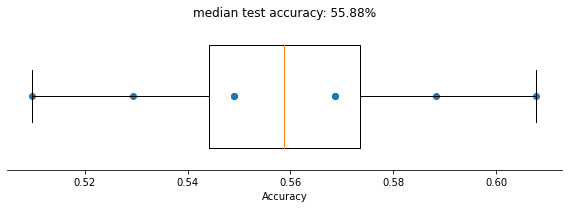

In [31]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(y_valid_acc, vert=False, widths=.7)
ax.scatter(y_valid_acc, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"median test accuracy: {np.median(y_valid_acc):.2%}"
)
ax.spines["left"].set_visible(False)